In [1]:
from math import ceil
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr

from matplotlib import pyplot as plt

In [2]:
def rmse(A,B):
    return np.sqrt(np.average((A-B)**2))
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def tanh(x):
    return np.tanh(x) 

def relu(x):
    return np.max(x,0)     

In [3]:
def velocity_verlet (b,m,y_0,tfinal):
    g = -9.81
    DeltaT = tfinal/25 # The smaller the better for DeltaT

    # set up arrays 
    n = ceil(tfinal/DeltaT) #Assuming tinitial=0

    # set up arrays for t, a, v, and y and we can compare our results with analytical ones
    t = np.zeros(n)
    a = np.zeros(n)
    v = np.zeros(n)
    y_vv = np.zeros(n)

    # Initial conditions (Change these if needed)
    v[0] = 0.0  #m/s
    y_vv[0] = y_0 #m

    # Start integrating using Euler-Cromer
    for i in range(n-1):
        # expression for acceleration
        a[i] = g - (b/m)*v[i]
        # update position
        y_vv[i+1] = y_vv[i] + v[i]*DeltaT + 0.5*a[i]*DeltaT**2
        # updated expression for acceleration
        a[i+1] = g - (b/m)*v[i+1]
        # update velocity
        v[i+1] = v[i] + 0.5*DeltaT*(a[i+1] + a[i])
        # update time to next time step and compute analytical answer
        t[i+1] = t[i] + DeltaT

    return y_vv

In [4]:
def y_analytic(x):
    '''
        Analytical solution of current problem
    '''
   # Define the drag constant, g, and the mass of the object
    b = 0.001
    g = -9.81
    m = 1.0

    # Set up the initial conditions (velocity and height)
    v_0 = 0
    y_0 = 0

    # Define the termminal velocity and the characteristic time
    v_ter = m*g/b
    tau = v_ter/g

    # Define the exact solution
    y_exact = v_ter*x + (v_0-v_ter)*tau*(1-np.exp(-x/tau))+y_0
    return y_exact

In [47]:
def f(t, y, v):
    '''
        d2(psy)/dx2 = f(x, dpsy/dx, psy)
        This is f() function on the right
    '''
    return -9.81-0.001*v

In [48]:
nt = 25
dt = 1. / nt
t_space = np.linspace(0, 2, nt)    
y_space = y_analytic(t_space)

     



In [49]:
def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def neural_network_x(x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])



In [50]:
def y_trial(ti, net_out):
    return ti + ti**2 * net_out

v = grad(y_trial)
a = grad(v)



In [51]:
def loss_function(W, x):
    loss_sum = 0.
    
    for xi in x:
        net_out = neural_network(W, xi)[0][0]

        net_out_d = grad(neural_network_x)(xi)
        net_out_dd = grad(grad(neural_network_x))(xi)
        
        psy_t = y_trial(xi, net_out)
        
        gradient_of_trial = v(xi, net_out)
        second_gradient_of_trial = a(xi, net_out)
        
        func = f(xi, psy_t, gradient_of_trial) # right part function
        
        err_sqr = (second_gradient_of_trial - func)**2
        loss_sum += err_sqr
        
    return loss_sum




In [52]:
W = [npr.randn(1, 10), npr.randn(10, 1)]
lmb = 0.001

for i in range(50):
    loss_grad =  grad(loss_function)(W, t_space)

    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]

res = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t_space] 


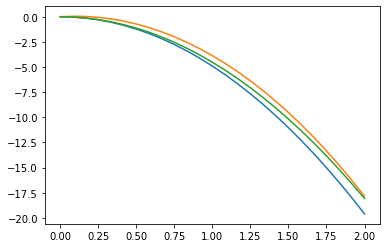

In [53]:
y_vv = velocity_verlet (0.001,1.0,0,2)

plt.figure()
plt.plot(t_space, y_space) 
plt.plot(t_space, res)
plt.plot(t_space,y_vv)
plt.show()

In [12]:
rmse(y_vv,y_space),rmse(y_space,res)

(0.70630900830357, 1.123859745214805)